# Assignment 7

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research.

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples.

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning.

# FILL IN CODE HERE #
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Datasci207/EuroSAT" # replace with your path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [ ]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data

    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)

    '''
    ## load images and labels
    # FILL IN CODE HERE #
    classes = np.array(sorted(os.listdir(path_to_data)))
    images = []
    labels = []

    for c in classes:
      label_path = os.path.join(path_to_data, c)
      for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = load_img(img_path)
        images.append(img_to_array(img))
        labels.append(c)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [ ]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (26999, 64, 64, 3)
Shape of labels  (26999,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

Text(0.5, 0, 'Labels')

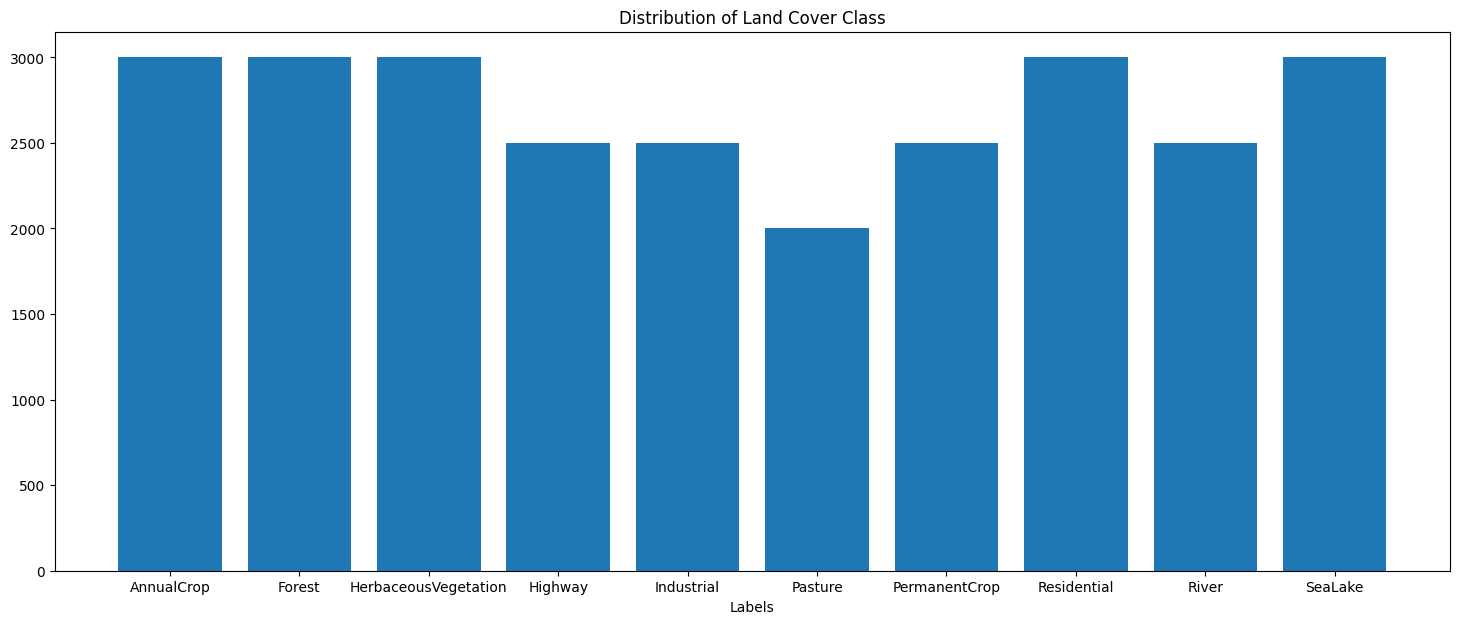

In [ ]:
# plotting class distribution
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(18, 7))
plt.bar(unique,counts)
plt.title("Distribution of Land Cover Class")
plt.xlabel("Labels")


The land cover class is not evenly distributed. Different categories make up different portions of the entire class. For example, the pasture class has about 2000 occurences while the annual crop class has about 3000. The classes are not balanced.

It is okay to plot the distribution before splitting test data because the makeup of the test data is still unknown to us. This means the "blindness" of the test data is still preserved.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

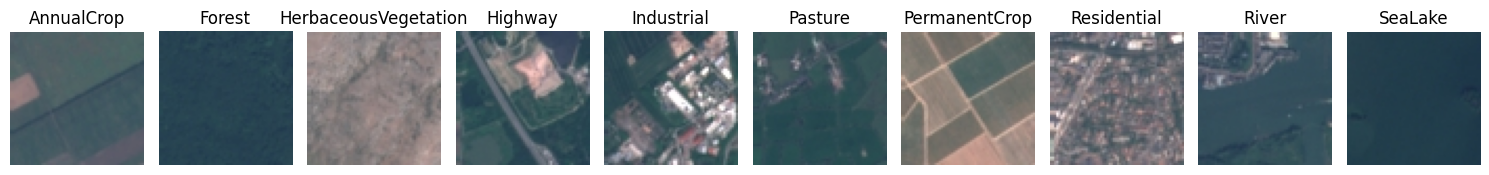

In [ ]:
#printing one image from each class
fig, axes = plt.subplots(1, len(unique), figsize=(15,3))

for i, c in enumerate(unique):
  class_ind = np.where(labels == c)[0][0]
  axes[i].imshow(images[class_ind].astype('uint8'))
  axes[i].set_title(c)
  axes[i].axis('off')

plt.tight_layout()
plt.show()

Most confused land classes: From looking at the examples from each class, it is likely that sea lake and forest are going to be the most confusted classes. The images do not have much color variation and are the same color as each other (almost).

---
### Step 3: Data preprocessing

Encode labels

In [ ]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(images, labels, split):
    '''Split data into train, validation and test sets.

    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # shuffle data
    indeces = np.arange(len(images))
    shuffled = np.random.permutation(indeces)

    # create data splits
    X_temp, X_test, Y_temp, y_test = train_test_split(images, labels, test_size = split[2], random_state = 1234)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, Y_temp, test_size = split[1]/(split[0] + split[1]), random_state = 1234)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16199, 64, 64, 3)
Shape of train labels  (16199,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation.

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only:
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [ ]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;

    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    data_partition (str): "train"

    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)

    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3

    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.random_flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis = 0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor


    # rescale image by dividing each pixel by 255.0
    X = X / 255.0

    return X, y

Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): It is important to add augmented images to training data because it increases the diversity and robustness of the model. Augmentation techniques like rotations, flips, and brightness adjustments simulate variations in real world satellite imagery, helping the model generalize better to unseen data. Augmentation should not be applied to validation and test sets because these sets need to represent the real world distribution of data as it would actually be encountered. Augmenting validation and test data would inflate performance metrics and give a false sense of model accuracy.

In [ ]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32398, 64, 64, 3)
Shape of train labels  (32398,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [ ]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32398, 12288)
Shape of train labels  (32398,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Validation Accuracy:  0.4488888888888889
Training Accuracy:  0.4843508858571517


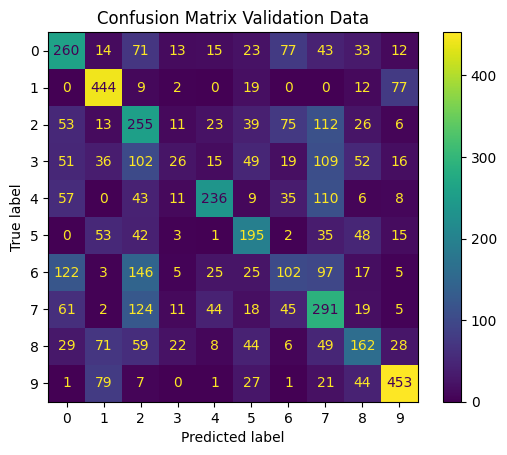

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#implementing decision forest classifier
rf_model = RandomForestClassifier(n_estimators = 2, n_jobs = 1, random_state = 7, max_depth = 8)

#training the model on X_train_Re and y_train
rf_model.fit(X_train_re, y_train)

#use model to make prediction
y_train_pred = rf_model.predict(X_train_re)
y_val_pred = rf_model.predict(X_val_re)

#determine accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy: ", val_accuracy)
print("Training Accuracy: ", train_accuracy)

#plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(y_val))
disp.plot()
plt.title("Confusion Matrix Validation Data")
plt.show()

Comment on model accuracy on training vs. validation data: The training and validation data accuracy differ by a small margin, with training accuracy being about 7.9% more accurate. Both are around 45%, which shows that the model is not accurate.

Does the model generalize well?: The model generalizes reasonably well, as the validation and training datasets have similar accuracies in this model.

Comment on the classes that the model confuses the most: The model confuses classes 6 and 2 the most (146 times). It predicts herbaceous vegetation in place of permanent crop. The images are largely similar in color profile, as seen in the example pictures shown in a previous problem. It does not seem to confuse the two labels in the opposite way.

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines:
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

Validation Accuracy:  0.5246296296296297
Training Accuracy:  0.6166430026544848


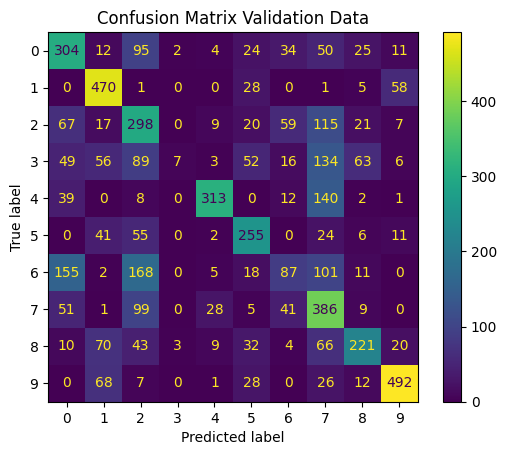

In [ ]:
#initialize the model
rf_clf2 = RandomForestClassifier(
    n_estimators=20,
    max_depth=8,
    max_features='sqrt',
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=7
)

#train the model
rf_clf2.fit(X_train_re, y_train)

#predict values
y_train_pred_2 = rf_clf2.predict(X_train_re)
y_val_pred_2 = rf_clf2.predict(X_val_re)

#compute accuracy
train_accuracy_2 = accuracy_score(y_train,y_train_pred_2)
val_accuracy_2 = accuracy_score(y_val,y_val_pred_2)

print("Validation Accuracy: ", val_accuracy_2)
print("Training Accuracy: ", train_accuracy_2)

#plot confusion matrix
cm_2 = confusion_matrix(y_val, y_val_pred_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix = cm_2, display_labels = np.unique(y_val))
disp_2.plot()
plt.title("Confusion Matrix Validation Data")
plt.show()

How your implementation is different compared to the baseline classifier:

Algorithm Parameters:
- n_estimators: Increased from 2 to 20 (more trees for better learning)
- max_features: Changed from default to 'sqrt' (reduces feature search space for faster training and regularization)
- min_samples_leaf: Added value of 5 (prevents overfitting by requiring minimum samples at leaf nodes)
- n_jobs: Changed from 1 to -1 (enables parallel processing on all CPU cores for faster training)

Comment on training vs. validation performance relative to baseline model: Both accuracies have increased by at least 10%, though the training and validation accuracies have a larger gap (about 9.02%). This shows that although accuracy has improved, generalization has not.

Comment on the classes the model confuses the most relative to the baseline: The model confuses the same exact classes the most, 2 and 6 (168 times is the most in the confusion matrix). It still predicts 2 the most in place of 6.

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [ ]:
#train the model
rf_clf2.fit(X_test_re, y_test)

#predict values
y_test_pred = rf_clf2.predict(X_test_re)

#compute accuracy
test_accuracy_2 = accuracy_score(y_test,y_test_pred)
print("Test Accuracy:" , test_accuracy_2)

Test Accuracy: 0.7337037037037037


Comment on test set accuracy vs. training vs. validation set accuracy:

The test set accuracy (73.37%) is notably higher than both the training accuracy (61.66%) and validation accuracy (52.46%). The significant improvement on the test set could indicate that the test set is easier or more representative of the model's learned patterns, or the test set may contain different image characteristics that align better with the training data. Despite this anomaly, the model demonstrates reasonable generalization with the validation-test gap being only about 20%.

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

Decision Forests are not ideal for land cover classification because they lose spatial information when images are flattened into feature vectors. Flattening a 64×64×3 satellite image into 12,288 features destroys the spatial structure where nearby pixels are more relevant than distant ones. Decision trees cannot capture this. Additionally, Decision Forests have limited feature learning capabilities. They cannot learn hierarchical features the way deep learning models can. With such high dimensional data, trees become memory intensive and struggle to capture the complex patterns in satellite imagery. Overall, Decision Forests tend to significantly underperform compared to deep learning approaches on image classification tasks.

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

Convolutional Neural Networks (CNNs) are much better suited for land cover classification because they are specifically designed to work with image data. CNNs preserve spatial relationships through convolutional operations, automatically learning hierarchical features that progress from simple patterns to complex objects. They excel at image classification tasks and consistently achieve higher accuracy than traditional machine learning methods. CNNs can extract meaningful features directly from raw pixels without manual feature engineering, making them more effective for satellite imagery analysis. For production level land cover classification, a CNN would be the clear choice.